# CNN
卷积神经网络可以以下图概括    

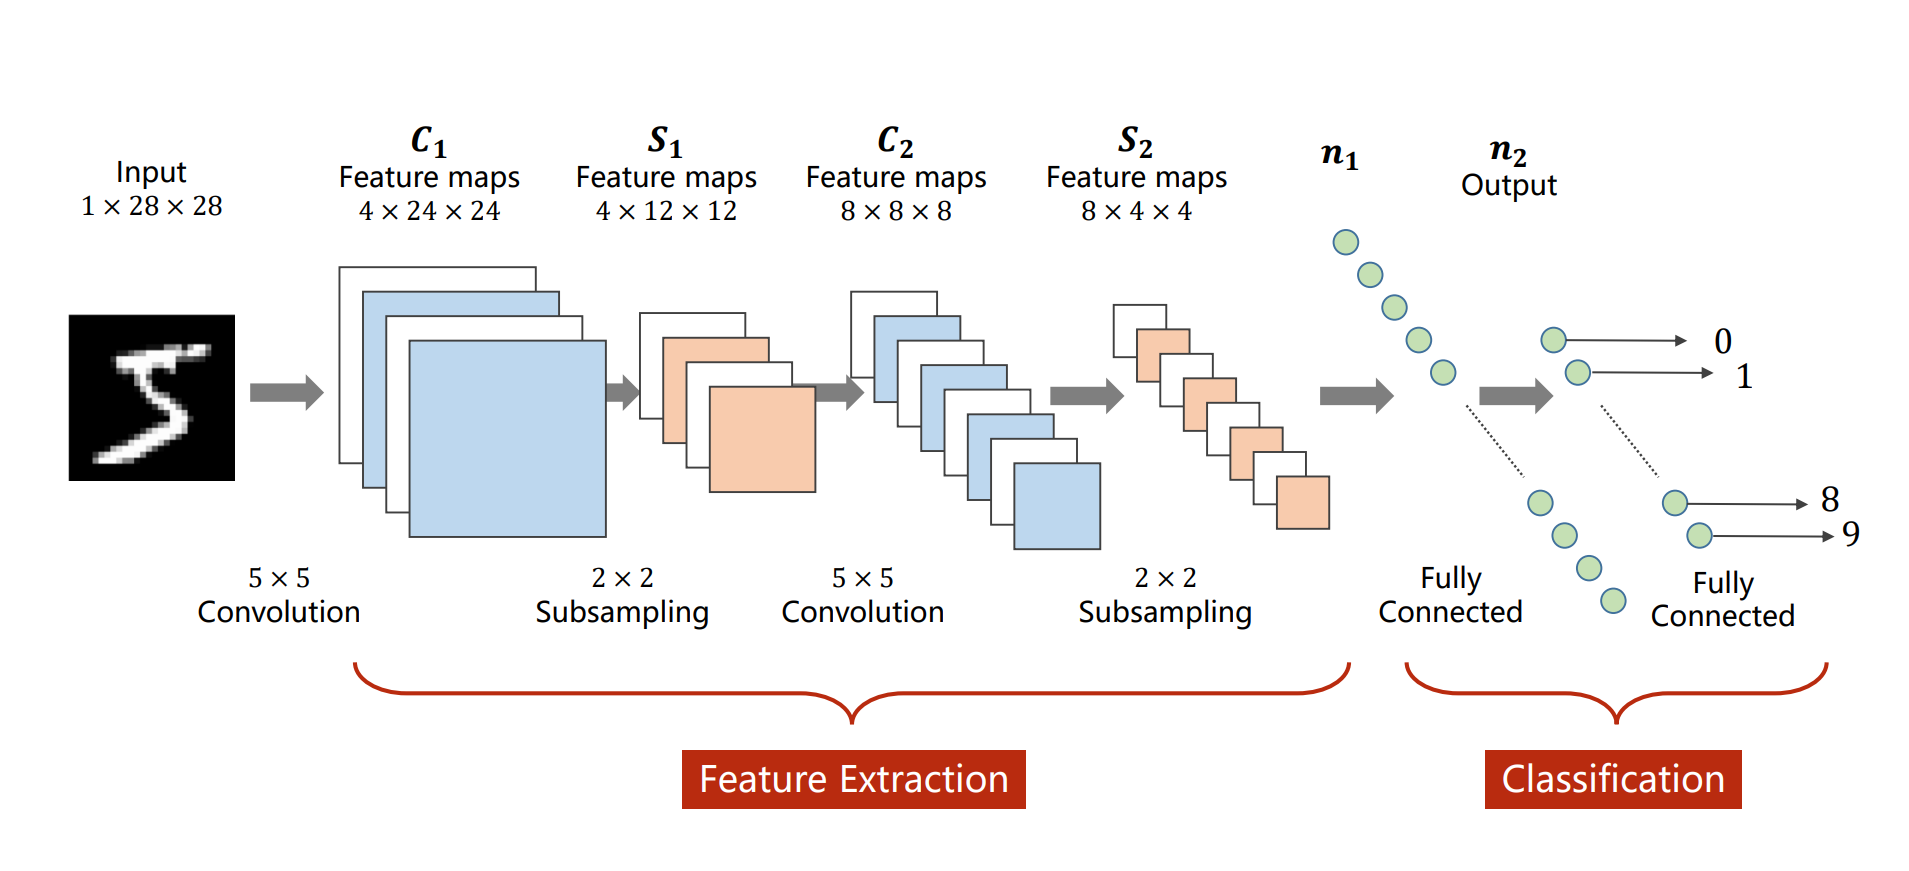

### 举例说明
假设有一张图片尺寸为25 * 25 * 3，其中25代表长和宽，3代表三个RGB通道，那么这个就是图像输入

##### 卷积核
卷积核则可以为5 * 5 * 3，期中5代表卷积核的长和宽，3代表卷积核的通道数，注意
- 一个卷积核是三维的，而不是单纯的二维5 * 5，通道数也要算在内
- 卷积核的第三个维度/第一个维度，一定要和图像的通道数一致
- 每个通道的卷积权重数值是不一样的
由此25 * 25的图像在5 * 5的卷积计算下得到的特征尺寸为21 * 21，算上通道数则为21 * 21 * 3
最后，在卷积计算完成后，每个通道数的结果需要拼在一起合并，即最后的输出是21 * 21 * 1

##### 步长
卷积核在计算的时候，一次可能移动不止1步，如果移动2步，上面的卷积结果就变为
(25 - 5)/ 2 + 1 = 11，即11 * 11

##### 填充
如果考虑到填充，比如在外部填充一层，那么卷积结果为
(25 - 5 + 1 * 2)/2 + 1 = 12，即12 * 12

综上，单纯考虑卷积运算，不考虑通道数，输入和输出的关系如下
$$
输出 = \frac{图像长/宽 - 卷积核长/宽 + 填充 * 2}{步长} + 1
$$

##### 池化
池化分为最大池化和平均池化，在一个n * n的尺寸下计算即可，注意这里不是一步步平移的，池化的尺寸计算如下
$$
输出 = \frac{输入长/宽 - 池化核长/宽}{步长} + 1
$$

##### 整体维度
如下图所示，之所以CNN总是让人感觉越来越粗是因为其粗细取决于卷积核的个数，有m个卷积和那么一层卷积计算后的长度即为m
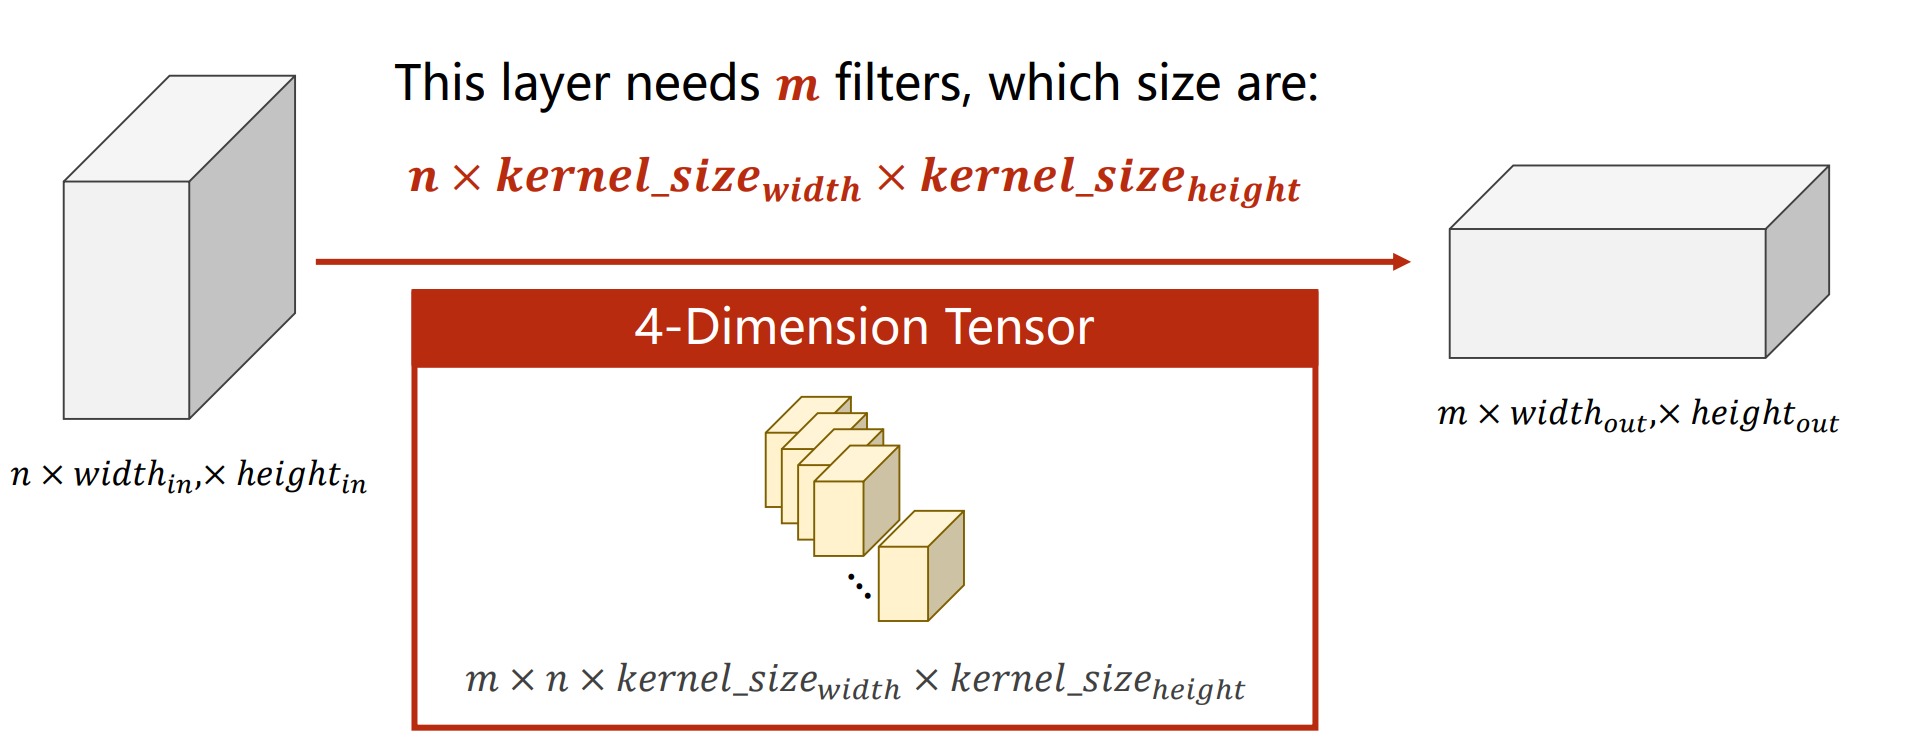

### 经典CNN之LeNet实现

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        # 卷积层：输入通道 1，输出通道 6，卷积核 5×5
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        # 池化层：2×2 平均池化
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        # 卷积层：输入通道 6，输出通道 16，卷积核 5×5
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 池化层：2×2 平均池化
        self.pool2 = nn.AvgPool2d(2, 2)
        # 全连接层：16×5×5 → 120
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # 全连接层：120 → 84
        self.fc2 = nn.Linear(120, 84)
        # 全连接层：84 → num_classes
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        # x: [batch, 1, 32, 32]
        x = F.relu(self.conv1(x))   # → [batch, 6, 28, 28]
        x = self.pool1(x)           # → [batch, 6, 14, 14]
        x = F.relu(self.conv2(x))   # → [batch, 16, 10, 10]
        x = self.pool2(x)           # → [batch, 16, 5, 5]
        x = x.view(x.size(0), -1)   # 拉平 → [batch, 16*5*5]
        x = F.relu(self.fc1(x))     # → [batch, 120]
        x = F.relu(self.fc2(x))     # → [batch, 84]
        x = self.fc3(x)             # → [batch, num_classes]
        return x

if __name__ == "__main__":
    # 实例化模型
    model = LeNet5(num_classes=10)
    # 生成随机输入：batch_size=4，单通道，32×32 图像
    inputs = torch.randn(4, 1, 32, 32)
    # 前向传播
    outputs = model(inputs)
    print("输入形状:", inputs.shape)
    print("输出形状:", outputs.shape)  # 应该是 [4, 10]


### 经典CNN之AlexNet实现

AlexNet 相比 LeNet 的主要改进
1. 更深、更宽的网络结构
- LeNet 只有 2 个卷积层，AlexNet 扩展到 5 层卷积，通道数也大幅增加（从最多 16→256），大大增强了表达能力。

2. 大感受野的首层设计
- AlexNet 第一层使用了 11×11、stride=4 的大卷积核，能够迅速增大感受野，捕捉输入的全局信息；LeNet 则用的是 5×5。

3. ReLU 激活
-首次在大规模网络中采用了 ReLU 替代 sigmoid/tanh，加速了收敛并缓解了梯度消失。

4. 最大池化 (MaxPool) 替代平均池化
- AlexNet 中多处使用 MaxPool2d，能够更强地保留显著特征；LeNet 最初使用的是 AvgPool（子采样）。

5. Dropout
- 在全连接层中引入 Dropout（丢弃率默认 0.5），有效抑制过拟合；LeNet 并无此机制。

6. 局部响应归一化 (LRN)
- 原始论文里还使用了 LRN 来增强“亮点”响应，不过在很多现代实现中可用 BatchNorm 代替或省略。

7. 更大的输入尺寸
- AlexNet 处理 224×224 的彩色图像，而 LeNet 通常只针对 32×32 的灰度小图。

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        # 特征提取部分：5 层卷积 + 3 次最大池化
        self.features = nn.Sequential(
            # C1: 3→64, 11×11 卷积, 步幅4, pad2
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # C2: 64→192, 5×5 卷积, pad2
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # C3: 192→384, 3×3 卷积, pad1
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # C4: 384→256, 3×3 卷积, pad1
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # C5: 256→256, 3×3 卷积, pad1
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        # 分类部分：3 层全连接 + Dropout
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        # 拉平
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

if __name__ == "__main__":
    # 实例化并测试前向传播
    model = AlexNet(num_classes=1000)
    # 随机输入：batch=4, 通道=3, 尺寸=224×224
    inputs = torch.randn(4, 3, 224, 224)
    outputs = model(inputs)
    print("输入形状:", inputs.shape)    # torch.Size([4, 3, 224, 224])
    print("输出形状:", outputs.shape)  # torch.Size([4, 1000])


### 经典CNN之VGG

VGG 相比 LeNet/AlexNet 的主要改进
1. 更深的网络结构
- VGG-16 在卷积部分堆叠了 13 个卷积层（+ 5 个池化），总层数超过 16 层，而 AlexNet 只有 5 层卷积，LeNet 仅 2 层。更深的网络能够抽取更高层次、更抽象的特征。

2. 统一的小卷积核设计
- 全部使用 $3\times3$ 卷积核（padding=1 保持尺寸），多个 $3\times3$ 卷积叠加的感受野等价于一个大卷积核（例如两个 $3\times3$ 等同于一个 $5\times5$），但参数更少、非线性更多。

3. 更多的非线性激活
- 每个卷积层后都紧跟 ReLU，相比 AlexNet 在每对大卷积后才有一次 ReLU，VGG 在更细粒度上增加了非线性，提升了表达能力和网络深度的有效利用。

4. 更严格的架构规范
- VGG 提出了“层叠 $3\times3$ + ReLU + 池化”的固定模块化设计，易于重复使用和扩展；AlexNet 则在不同层使用了不同大小卷积核，架构相对杂糅。

5. 大量的参数与更强的拟合能力
- VGG-16 全连接层就包含上亿级参数，总参数量达到 $\sim$138M，相比 AlexNet 的 $\sim$60M 更大，能够拟合更复杂的模式（代价是更多的计算和存储）。

6. 更深通道宽度
- 随着网络加深，通道数从 64、128→256、512 逐步增长，能层次化地提取从低级边缘纹理到高级语义区域的特征。

In [1]:
import torch
import torch.nn as nn

# VGG-16 的配置表
cfgs = {
    'VGG16': [64, 64, 'M',
              128, 128, 'M',
              256, 256, 256, 'M',
              512, 512, 512, 'M',
              512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, arch='VGG16', num_classes=1000):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfgs[arch])
        # 最后 feature map 大小为 512×7×7 → 展平 → FC
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        # 最后再加一个全局平均（可选），原版用的是直接输出 feature map
        return nn.Sequential(*layers)


if __name__ == "__main__":
    model = VGG('VGG16', num_classes=1000)
    # 随机输入：batch=4, 通道=3, 尺寸=224×224
    inputs = torch.randn(4, 3, 224, 224)
    outputs = model(inputs)
    print("输入形状:", inputs.shape)    # torch.Size([4, 3, 224, 224])
    print("输出形状:", outputs.shape)  # torch.Size([4, 1000])


输入形状: torch.Size([4, 3, 224, 224])
输出形状: torch.Size([4, 1000])


### 经典CNN之NiN
1. **引入 MLPconv（微型网络卷积）**
- 用一系列 $1\times1$ 卷积代替传统的单线性通道映射，增强了局部区域内的跨通道非线性建模能力。

2. **去除大规模全连接层，采用全局平均池化**
- 最后用 AdaptiveAvgPool2d((1,1)) 替代大参数量的全连接层，显著减少模型参数并提高空间位置不变性。
- 比如要分为1000类，那么最后一层输出的通道数必须为1000，整体尺寸为1000 * w * h，全局平均池化用的核大小也为w * h，将每一个通道的w * h个元素求均值，就得到1000 * 1个值，每个值代表一个分类的概率，最后接一个softmax即可；有点简单粗暴的。

3. 局部模型复杂度提升
- NiN 在每个感受野上都做了更深的非线性变换，使得网络能在更小的局部窗口内学到更复杂的特征。

4. 参数高效
- 虽然网络更深，但大量使用 $1\times1$ 卷积使得参数量相比 AlexNet/VGG 更加节省。

5. 自然的正则化
- 全局平均池化将每个类别的预测直接映射为对应通道的平均激活，减少过拟合并增强了特征与类别的对应关系。

6. Dropout 融合
- 在 Pooling 之后加 Dropout（丢弃率 0.5），进一步抑制过拟合，提升泛化。

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NiN(nn.Module):
    def __init__(self, num_classes=1000):
        super(NiN, self).__init__()
        self.features = nn.Sequential(
            # Block1
            nn.Conv2d(3, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 160, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(160, 96, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Dropout(0.5),
            # Block2
            nn.Conv2d(96, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Dropout(0.5),
            # Block3
            nn.Conv2d(192, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, num_classes, kernel_size=1),
            nn.ReLU(inplace=True),
            # 全局平均池化，输出 num_classes 个通道
            nn.AdaptiveAvgPool2d((1, 1))
        )

    def forward(self, x):
        x = self.features(x)            # [batch, num_classes, 1, 1]
        x = x.view(x.size(0), -1)       # 拉平成 [batch, num_classes]
        return x

if __name__ == "__main__":
    model = NiN(num_classes=1000)
    # 随机输入：batch=4, 通道=3, 尺寸=224×224
    inputs = torch.randn(4, 3, 224, 224)
    outputs = model(inputs)
    print("输入形状:", inputs.shape)    # torch.Size([4, 3, 224, 224])
    print("输出形状:", outputs.shape)  # torch.Size([4, 1000])


### 经典CNN之GoogleNet
1. Inception 模块（多尺度并行卷积）
- 同一层级并行应用 $1\times1$、$3\times3$、$5\times5$ 卷积和池化，通过拼接融合多尺度特征，增强了表达能力。

2. 维度压缩（1×1 卷积降维）
- 在 $3\times3$ 和 $5\times5$ 卷积前先用 $1\times1$ 卷积减少通道数，大量降低计算量和参数规模。

3. 更深、更宽且参数可控
- 网络深度达到 22 层（含池化和辅助分类），但通过 Inception 结构参数量只有 ∼5M，比 VGG/AlexNet 少得多。

4. 辅助分类器（Auxiliary Classifiers）
- 在中间层添加两个小型分类器，帮助缓解梯度消失，提供额外正则化，训练时提升早期层的有效梯度信号。

5. 全局平均池化
- 最终用全局平均池化替代全连接大层，进一步减少参数并强化空间不变性。

6. 更好的计算效率
- 通过 Inception 模块的并行多尺度卷积和降维技术，在保持或提升性能的同时，大幅减少了 FLOPs，提高了训练和推理速度。

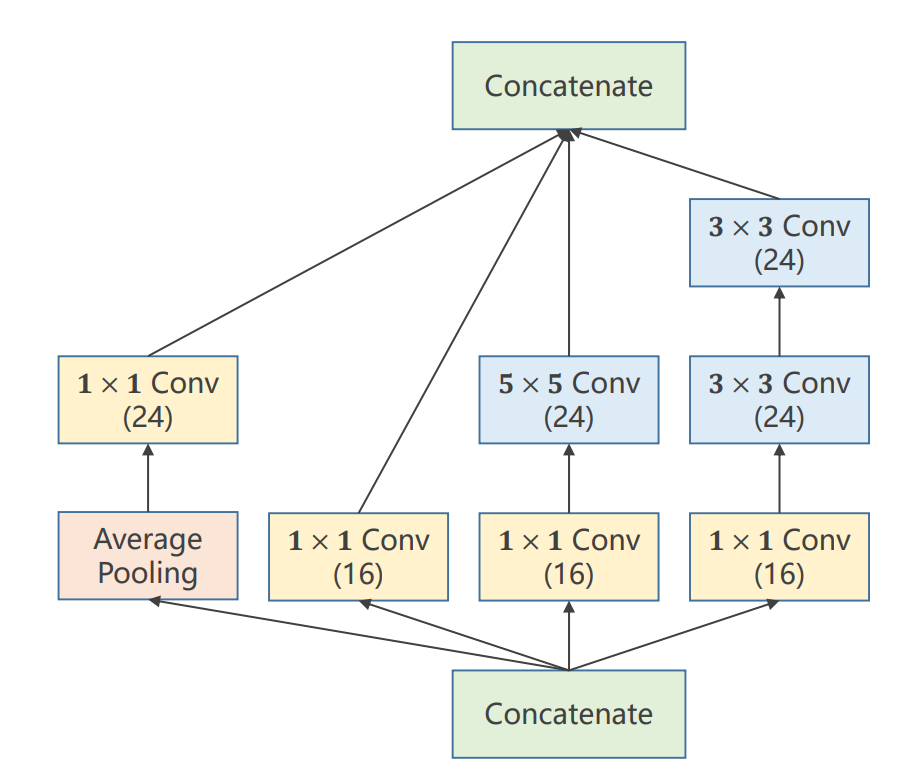

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Inception(nn.Module):
    def __init__(self, in_channels, c1, c3_reduce, c3, c5_reduce, c5, pool_proj):
        super(Inception, self).__init__()
        # 1×1 分支
        self.branch1 = nn.Conv2d(in_channels, c1, kernel_size=1)

        # 1×1 → 3×3 分支
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, c3_reduce, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(c3_reduce, c3, kernel_size=3, padding=1),
        )

        # 1×1 → 5×5 分支
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, c5_reduce, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(c5_reduce, c5, kernel_size=5, padding=2),
        )

        # 3×3 池化 → 1×1 分支
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        b3 = self.branch3(x)
        b4 = self.branch4(x)
        # 拼接通道
        out = torch.cat([b1, b2, b3, b4], dim=1)
        return self.relu(out)

class AuxClassifier(nn.Module):
    """辅助分类器"""
    def __init__(self, in_channels, num_classes):
        super(AuxClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.AdaptiveAvgPool2d((4, 4)),
            nn.Conv2d(in_channels, 128, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.7),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        return self.net(x)

class GoogleNet(nn.Module):
    def __init__(self, num_classes=1000, aux_logits=True):
        super(GoogleNet, self).__init__()
        self.aux_logits = aux_logits

        # stem: 前几层卷积＋池化
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2, padding=1),
            nn.Conv2d(64, 64, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2, padding=1),
        )

        # Inception 模块
        self.in3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.in3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool = nn.MaxPool2d(3, 2, padding=1)

        self.in4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.in4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.in4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.in4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.in4e = Inception(528, 256, 160, 320, 32, 128, 128)

        self.in5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.in5b = Inception(832, 384, 192, 384, 48, 128, 128)

        # 辅助分类器
        if aux_logits:
            self.aux1 = AuxClassifier(512, num_classes)
            self.aux2 = AuxClassifier(528, num_classes)
        else:
            self.aux1 = self.aux2 = None

        # 全局平均池化＋FC
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pre_layers(x)
        x = self.in3a(x)
        x = self.in3b(x)
        x = self.maxpool(x)

        x = self.in4a(x)
        # 第一个辅助输出分支
        aux1 = self.aux1(x) if self.aux_logits and self.training else None

        x = self.in4b(x)
        x = self.in4c(x)
        x = self.in4d(x)
        # 第二个辅助输出分支
        aux2 = self.aux2(x) if self.aux_logits and self.training else None

        x = self.in4e(x)
        x = self.maxpool(x)

        x = self.in5a(x)
        x = self.in5b(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        logits = self.fc(x)

        if self.aux_logits and self.training:
            return logits, aux1, aux2
        return logits

if __name__ == "__main__":
    net = GoogleNet(num_classes=1000, aux_logits=True)
    imgs = torch.randn(4, 3, 224, 224)
    outputs = net(imgs)
    if isinstance(outputs, tuple):
        main, a1, a2 = outputs
        print(main.shape, a1.shape, a2.shape)  # [4,1000], [4,1000], [4,1000]
    else:
        print(outputs.shape)


torch.Size([4, 1000]) torch.Size([4, 1000]) torch.Size([4, 1000])


### 经典CNN之ResNet
1. 残差连接（Skip Connection）
- 引入快捷通道，将输入直接加到卷积输出上，形成“残差学习”，有效缓解了深层网络的梯度消失和退化问题。

2. 易于训练更深的网络
- 通过残差块，ResNet 可以无障碍地扩展到上百层，使模型获得更强的表达能力，而不致于性能下降。

3. BatchNorm
- 在每次卷积后加入批量归一化，进一步稳定训练，加快收敛速度。

4. 统一的小卷积核设计
- 所有卷积层均采用 $3\times3$，与 VGG 一致，但通过残差结构保证更深网络的可训练性。

5. 全局平均池化
- 在分类前使用全局平均池化代替大规模全连接层，减少参数量，降低过拟合风险。

6. 模块化与可扩展性
- BasicBlock / BottleneckBlock 等模块化设计，便于快速搭建 ResNet-34、ResNet-50、ResNet-101 等更深结构。

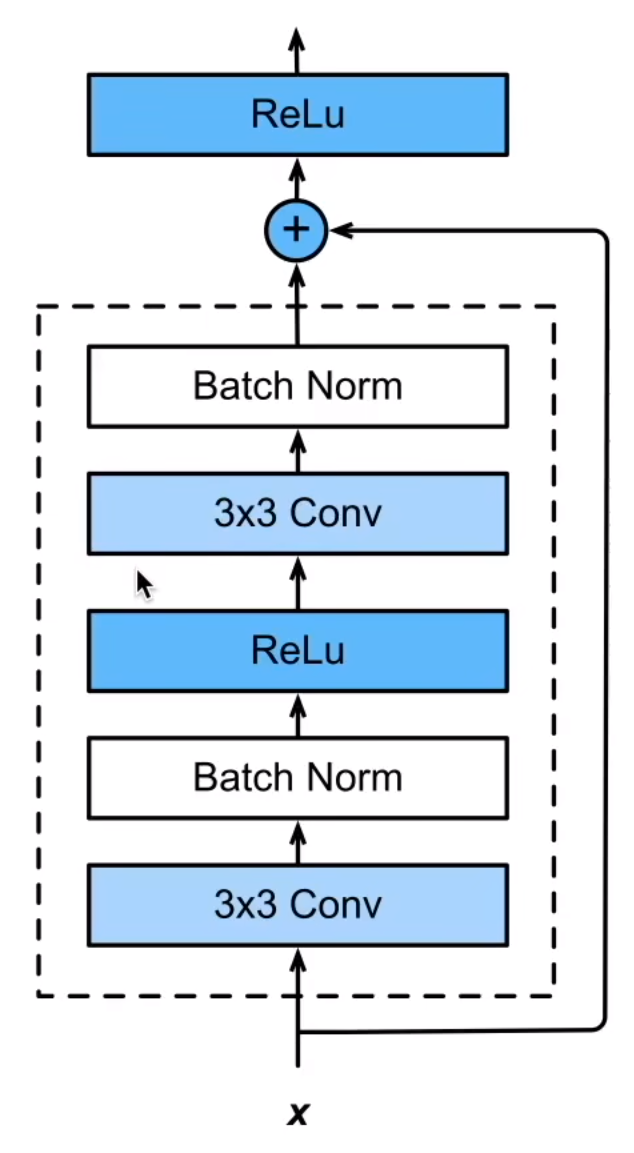


In [3]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        # 第一层 3×3 卷积 + BN + ReLU
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        # 第二层 3×3 卷积 + BN
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        # 下采样分支，用于尺寸或通道数不匹配时
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        # 如果有下采样，就把 identity 也映射到相同维度
        if self.downsample is not None:
            identity = self.downsample(x)
        # 残差连接
        out += identity
        return self.relu(out)

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_planes = 64
        # Stem: 大卷积 + BN + ReLU + 最大池化
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # 四个阶段，每个阶段堆叠若干 BasicBlock
        self.layer1 = self._make_layer(block,  64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # 全局平均池化 + 全连接分类
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc      = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride):
        downsample = None
        # 如果步幅不是1或通道数变化，则需要下采样
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        # 第一个 block 可能需要下采样
        layers.append(block(self.in_planes, planes, stride, downsample))
        self.in_planes = planes * block.expansion
        # 其余 block
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

def resnet18(num_classes=1000):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

if __name__ == "__main__":
    model = resnet18(num_classes=1000)
    # 随机输入：batch=4, 通道=3, 尺寸=224×224
    inputs = torch.randn(4, 3, 224, 224)
    outputs = model(inputs)
    print("输入形状:", inputs.shape)    # torch.Size([4, 3, 224, 224])
    print("输出形状:", outputs.shape)  # torch.Size([4, 1000])


输入形状: torch.Size([4, 3, 224, 224])
输出形状: torch.Size([4, 1000])
